# Drinking water filtration recommendation by region

The objective is to recommend one of four types of filters based on recorded contaminants and water qualities:

1. Activated Carbon Filter
2. Ion Exchange
3. Distillation
4. Reverse Osmosis

note: Orange County and San Diego recommendations are not available in the data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix, roc_curve, auc, precision_score, recall_score, accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier


import sys
import six
sys.modules['sklearn.externals.six'] = six
from imblearn.over_sampling import SMOTE

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

base = pd.read_csv('base.csv')
base.head()

,SAMPLE_YEAR,MCL,filters,Superior_California,North_Coast,San_Francisco,Northern_San_Joaquin_Valley,Central_Coast,Southern_San_Joaquin_Valley,Inland_Empire,Los_Angeles,Turbidity,Hardness,"1,1-Dichloroethane","1,1,1-Trichloroethane","1,1,2-Trichloroethane","1,1,2,2-Tetrachloroethane","1,2-Dibromo-3-chloropropane (DBCP)","1,2-Dichlorobenzene","1,2-Dichloroethane","1,2-Dichloropropane","1,2,3-Trichloropropane","1,2,4-Trichlorobenzene","1,4-Dichlorobenzene","2,4,5-TP (Silvex)",Alachlor,Aluminum,Antimony,Arsenic,Atrazine,Barium,Benzene,Beryllium,BHC-gamma (Lindane),Cadmium,Carbofuran,Carbon tetrachloride,Chlordane,Chromium,"cis-1,3-Dichloropropene",Copper,Dinoseb (DNPB),Endrin,Fluoride,Glyphosate,Heptachlor,Heptachlor epoxide,Lead,Mercury,Methoxychlor,Molinate,Nickel,Nitrate,Nitrate + Nitrite,Nitrite,Oxamyl,Pentachlorophenol (PCP),Picloram,Selenium,Simazine,Strontium,Styrene,Thallium,Thiobencarb,Toluene,Toxaphene,"trans-1,3-Dichloropropene",Trichlorofluoromethane,Vinyl chloride,Groundwater,Other,Surface Water
0,2016,0.2,Activated Carbon Filter,0,0,1,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1
1,2012,0.2,Activated Carbon Filter,0,0,1,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1
2,2016,0.2,Activated Carbon Filter,0,0,1,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1
3,2019,0.2,Activated Carbon Filter,0,0,1,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1
4,2012,0.2,Activated Carbon Filter,0,0,1,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1


In [2]:
# set target filter type by number
conditions = [((base['filters'] == 'Activated Carbon Filter')),
              ((base['filters'] == 'Ion Exchange')),
              ((base['filters'] == 'Distillation')),
              ((base['filters'] == 'Reverse Osmosis'))]
choices = [1,2,3,4]
#len(conditions)
base['filters'] = np.select(conditions, choices, default=0)

In [3]:
# include only the key contaminants identified in the EDA: Turbidity, Hardness, 
# Copper, Lead, Nitrates, Nitrites, Barium, Fluoride

base = base[['Turbidity', 'Hardness', 'Copper', 'Lead', 'Nitrate', 'Nitrite', 
             'Nitrate + Nitrite', 'Barium', 'Fluoride', 'filters', 
             'Superior_California', 'North_Coast', 'San_Francisco',
             'Northern_San_Joaquin_Valley', 'Central_Coast', 'Southern_San_Joaquin_Valley',
             'Inland_Empire', 'Los_Angeles']]
base.head()

,Turbidity,Hardness,Copper,Lead,Nitrate,Nitrite,Nitrate + Nitrite,Barium,Fluoride,filters,Superior_California,North_Coast,San_Francisco,Northern_San_Joaquin_Valley,Central_Coast,Southern_San_Joaquin_Valley,Inland_Empire,Los_Angeles
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,1,0,0,0,0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,1,0,0,0,0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,1,0,0,0,0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,1,0,0,0,0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,1,0,0,0,0,0


In [4]:
cats = base.filter(['Superior_California', 'North_Coast', 'San_Francisco', 
            'Northern_San_Joaquin_Valley', 'Central_Coast', 'Southern_San_Joaquin_Valley', 
            'Inland_Empire', 'Los_Angeles','Groundwater','Other','Surface Water'])
conts = base.drop(cats, axis=1)
conts = conts.drop('filters', axis=1)

y = base['filters']
x = pd.concat([cats,conts], axis = 1)

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=13)

## KNN

In [6]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))

0.9713588164559268


                         precision    recall  f1-score   support

Activated Carbon Filter       0.98      0.99      0.98     19580
           Ion Exchange       0.84      0.81      0.83       774
           Distillation       0.96      0.92      0.94      4918
        Reverse Osmosis       1.00      1.00      1.00      2171

               accuracy                           0.97     27443
              macro avg       0.94      0.93      0.94     27443
           weighted avg       0.97      0.97      0.97     27443



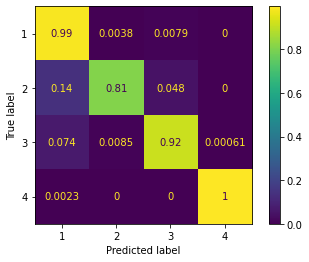

In [7]:
print(classification_report(y_test, knn.predict(X_test), target_names=['Activated Carbon Filter',
                                                               'Ion Exchange', 
                                                               'Distillation',
                                                               'Reverse Osmosis']))
plot_confusion_matrix(knn, X_test, y_test, normalize='true')

notes:

## Decision Tree

In [8]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9750391721021754


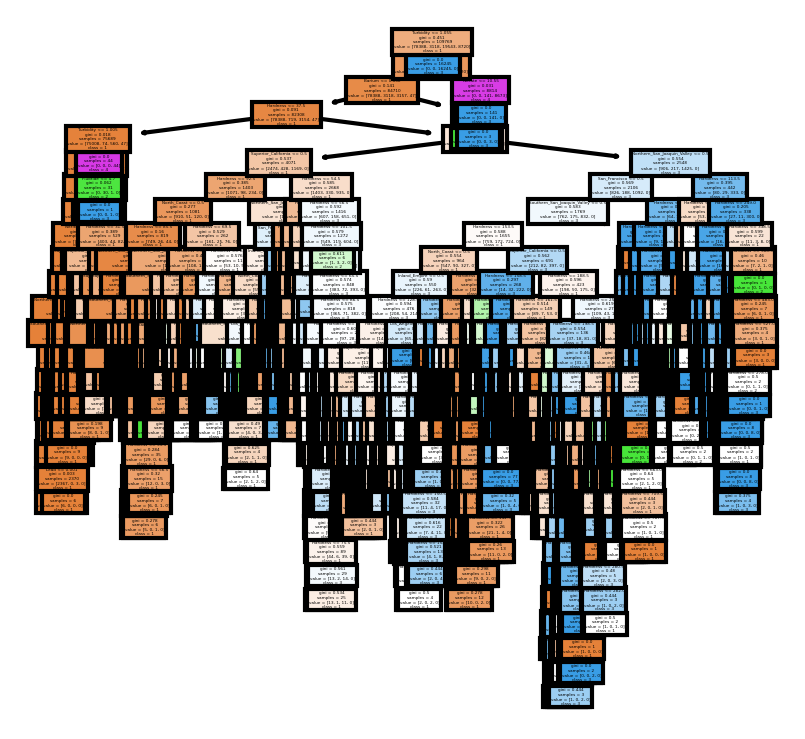

In [9]:
fig, axes = plt.subplots(nrows = 1,ncols = 1, figsize = (3,3), dpi=300)
tree.plot_tree(clf,
               feature_names = x.columns, 
               class_names=np.unique(y).astype('str'),
               filled = True)
plt.show()

In [10]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=['Activated Carbon Filter',
                                                               'Ion Exchange', 
                                                               'Distillation',
                                                               'Reverse Osmosis']))

[[19557    18   126     0]
 [  103   594    46     0]
 [  375    17  4465     0]
 [    0     0     0  2142]]
                         precision    recall  f1-score   support

Activated Carbon Filter       0.98      0.99      0.98     19701
           Ion Exchange       0.94      0.80      0.87       743
           Distillation       0.96      0.92      0.94      4857
        Reverse Osmosis       1.00      1.00      1.00      2142

               accuracy                           0.98     27443
              macro avg       0.97      0.93      0.95     27443
           weighted avg       0.97      0.98      0.97     27443



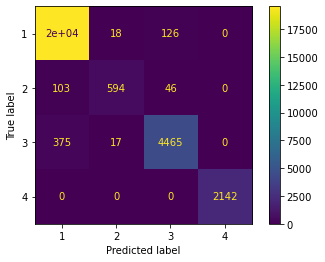

In [12]:
plot_confusion_matrix(clf, X_test, y_test)

### prune

In [13]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier(criterion="entropy", max_depth=3)

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9638523485041722


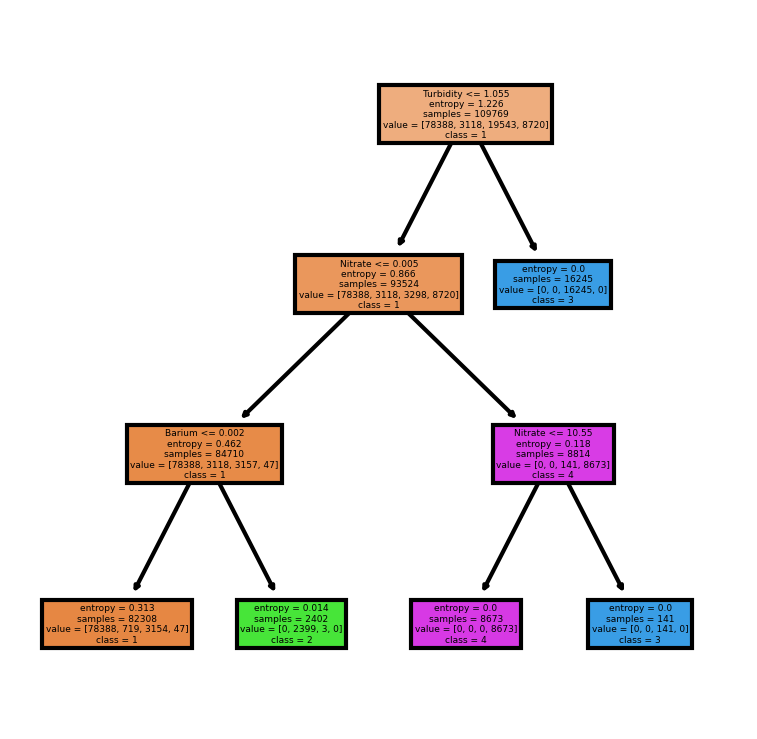

In [14]:
fig, axes = plt.subplots(nrows = 1,ncols = 1, figsize = (3,3), dpi=300)
tree.plot_tree(clf,
               feature_names = x.columns, 
               class_names=np.unique(y).astype('str'),
               filled = True)
plt.show()

In [15]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=['Activated Carbon Filter',
                                                               'Ion Exchange', 
                                                               'Distillation',
                                                               'Reverse Osmosis']))

[[19701     0     0     0]
 [  171   572     0     0]
 [  809     1  4047     0]
 [   11     0     0  2131]]
                         precision    recall  f1-score   support

Activated Carbon Filter       0.95      1.00      0.98     19701
           Ion Exchange       1.00      0.77      0.87       743
           Distillation       1.00      0.83      0.91      4857
        Reverse Osmosis       1.00      0.99      1.00      2142

               accuracy                           0.96     27443
              macro avg       0.99      0.90      0.94     27443
           weighted avg       0.97      0.96      0.96     27443



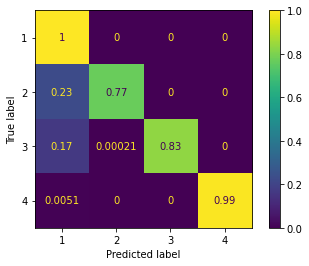

In [17]:
plot_confusion_matrix(clf, X_test, y_test, normalize='true')

notes:

## Random Forest

In [18]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
forest = Pipeline([('ss', StandardScaler()), 
                   ('forest', RandomForestClassifier(
                     n_estimators=150, 
                     max_depth= 20,
                     min_samples_leaf = 1, 
                     random_state = 123))])

forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9765696170243778


                         precision    recall  f1-score   support

Activated Carbon Filter       0.98      0.99      0.98     19641
           Ion Exchange       0.95      0.83      0.89       754
           Distillation       0.96      0.93      0.94      4861
        Reverse Osmosis       1.00      1.00      1.00      2187

               accuracy                           0.98     27443
              macro avg       0.97      0.94      0.95     27443
           weighted avg       0.98      0.98      0.98     27443



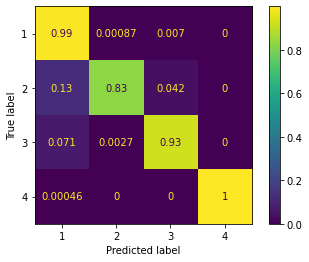

In [19]:
print(classification_report(y_test, forest.predict(X_test), target_names=['Activated Carbon Filter',
                                                               'Ion Exchange', 
                                                               'Distillation',
                                                               'Reverse Osmosis']))
plot_confusion_matrix(forest, X_test, y_test, normalize='true')

### smote

In [20]:
X_train_resampled, y_train_resampled = SMOTE(random_state=13).fit_sample(X_train, y_train) 

In [21]:
forest = Pipeline([('ss', StandardScaler()), 
                   ('forest', RandomForestClassifier(
                     n_estimators=150, 
                     max_depth= 20,
                     min_samples_leaf = 1, 
                     random_state = 13))])
forest.fit(X_train_resampled, y_train_resampled)
y_pred = forest.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9652734759319317


                         precision    recall  f1-score   support

Activated Carbon Filter       0.99      0.97      0.98     19641
           Ion Exchange       0.57      0.93      0.71       754
           Distillation       0.95      0.93      0.94      4861
        Reverse Osmosis       1.00      1.00      1.00      2187

               accuracy                           0.97     27443
              macro avg       0.88      0.96      0.91     27443
           weighted avg       0.97      0.97      0.97     27443



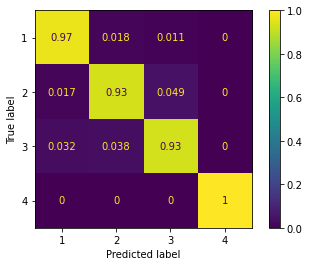

In [22]:
print(classification_report(y_test, forest.predict(X_test), target_names=['Activated Carbon Filter',
                                                               'Ion Exchange', 
                                                               'Distillation',
                                                               'Reverse Osmosis']))
plot_confusion_matrix(forest, X_test, y_test, normalize='true')

notes: this is the best model for true positives